In [1]:
import math
import sqlite3
from html import escape
from itertools import groupby
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.core.display import HTML
from docutils.core import publish_parts

%matplotlib inline
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('compression.db')

In [6]:
def render_rst(rst):
    """
    Given reStructuredText *rst*, return the rendered HTML
    content, excluding the surrounding outer-most ``<body>``
    elements.
    """
    return HTML(publish_parts(rst, writer_name='html')['html_body'])

In [7]:
render_rst(Path('README.rst').read_text())

Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


## Analysis Functions

Before performing the analysis itself, we define some convenience functions for
rendering the output of an SQL query against the database as HTML, and for
rendering certain queries as scatter graphs in various layouts.

In [8]:
def render_table(cur):
    """
    Given *cur*, a cursor containing a database result set, return a string
    containing the result set rendered as an HTML ``<table>`` element.
    """
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header))}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return HTML(f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>""")

In [9]:
def transpose(seq):
    return list(zip(*seq))

In [10]:
def render_xy(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results
    on an X-Y scatter graph. The cursor is expected to contain 3 columns:
    
    * The first column must be the "series" column, and must be the first
      column by which the result set is ordered. It can be any data-type but
      is typically a string indicating the series of data that the row belongs
      to. The name of this column is ignored, but the content will be used in
      the key of the graph.
      
    * The second column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The third column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 3:
        raise ValueError('query must return 3 columns')
    ax = plt.axes()
    for series, rows in groupby(cur, key=itemgetter(0)):
        data = transpose((row[1], row[2]) for row in rows)
        ax.plot(data[0], data[1], label=series, **style)
    ax.set_xlabel(cols[1])
    ax.set_ylabel(cols[2])
    ax.legend()
    return ax

In [11]:
def render_multi_xy(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    multiple X-Y scatter graphs within a figure. Each plot shares its X and
    Y scales making the graphs comparable. The cursor must contain 4 columns:
    
    * The first is the graph "title" column. The result set must use this as
      the primary sorting key. Each unique value in this column will produce a
      separate output graph titled with that value. The column name is ignored.
      
    * The second is the "series" column. The result set must use this as the
      secondary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The third column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The fourth column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 4:
        raise ValueError('query must return 4 columns')
    graphs = {}
    for title, rows in groupby(cur, key=itemgetter(0)):
        graphs[title] = [(row[1], row[2], row[3]) for row in rows]
    rows = len(graphs) // 2 + len(graphs) % 2
    fig, axs = plt.subplots(
        rows, 2, figsize=(10, rows * 5),
        sharex=True, sharey=True)
    for ax, title in zip(axs.flat, graphs):        
        graph = graphs[title]
        for series, rows in groupby(graph, key=itemgetter(0)):
            data = transpose((row[1], row[2]) for row in rows)
            ax.plot(data[0], data[1], label=series, **style)
        ax.set_xlabel(cols[2])
        ax.set_ylabel(cols[3])
        ax.legend()
        ax.set_title(title)
        ax.label_outer()
    if len(graphs) % 2:
        axs.flat[-1].set(visible=False)

In [12]:
def render_xyz(cur):
    """
    Given *cur*, a cursor containing a database result set, plot the results on
    three X-Y scatter graphs. The cursor is expected to contain 4 columns:
    
    * The first is the "series" column. The result set must use this as the
      primary sorting key. Each unique value in this column will form a
      separate series of data in the containing graph. The column name is
      ignored.
      
    * The second column must be the "X" column, and must be numeric values
      for the X-axis of the graph. The column name will be used as the X-axis
      title.
      
    * The third column must be the "Y" column, and must be numeric values for
      the Y-axis of the graph. The column name will be used as the Y-axis
      title.
      
    * The fourth column must be the "Z" column, and must be numeric values for
      the Z-axis of the graph. The column name will be used as the Z-axis
      title.
      
    The "X" and "Y" columns will be plotted on the top-left "common" graph. The
    "X" and "Z" columns will be plotted below the common graph, and the "Y" and
    "Z" columns will be plotted to the right of the common graph.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    cols = [c[0] for c in cur.description]
    if len(cols) != 4:
        raise ValueError('query must return 4 columns')
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    cur = list(cur)
    indexes = {'x': 1, 'y': 2, 'z': 3}
    for ax, ax_cols in zip(axs.flat, ('xy', 'zy', 'xz')):
        getter = itemgetter(indexes[ax_cols[0]], indexes[ax_cols[1]])
        for series, rows in groupby(cur, key=itemgetter(0)):
            data = transpose(getter(row) for row in rows)
            ax.plot(data[0], data[1], label=series, **style)
        ax.legend()
        ax.set_xlabel(cols[indexes[ax_cols[0]]])
        ax.set_ylabel(cols[indexes[ax_cols[1]]])
    axs[1, 1].set(visible=False)
    return fig

## Analysis Results

### Combinations tested

A list of all the machines (and architectures) tested:

In [13]:
render_table(conn.execute("""
SELECT DISTINCT
  machine AS "Machine",
  arch AS "Architecture"
FROM results
"""))

Machine,Architecture
AMD Ryzen 32GB,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2 512MB,arm64
Pi Zero 2 512MB,armhf


A list of all the compressors and options tested:

In [34]:
render_table(conn.execute("""
SELECT
  compressor AS "Compressor",
  options AS "Options",
  GROUP_CONCAT(level) AS "Levels"
FROM tests
GROUP BY compressor, options
ORDER BY compressor, options
"""))

Compressor,Options,Levels
bzip2,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
bzip2,-s,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
gzip,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,,"-1,-10,-11,-12,-2,-3,-4,-5,-6,-7,-8,-9"
lzip,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,-e,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,-T0,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"


Notes:
* The `-e` option for `xz` enables "extreme" (!) compression
* The `-s` option for `bzip2` reduces memory usage
* The `-T0` option for `zstd` enables multi-threaded operation

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [15]:
render_table(conn.execute("""
SELECT
  machine AS "Machine",
  arch AS "Architecture",
  compressor ||
  CASE WHEN options = '' THEN '' ELSE ' ' || options END ||
  CASE WHEN level = '' THEN '' ELSE ' ' || level END AS "Command"
FROM results
WHERE succeeded = 0
"""))

Machine,Architecture,Command
Pi Zero 2 512MB,arm64,xz -7
Pi Zero 2 512MB,arm64,xz -8
Pi Zero 2 512MB,arm64,xz -9
Pi Zero 2 512MB,arm64,xz -e -7
Pi Zero 2 512MB,arm64,xz -e -8
Pi Zero 2 512MB,arm64,xz -e -9
Pi Zero 2 512MB,arm64,zstd -16
Pi Zero 2 512MB,arm64,zstd -17
Pi Zero 2 512MB,arm64,zstd -18
Pi Zero 2 512MB,arm64,zstd -19


From the table above we can see that only the Pi Zero 2 has an issue, and that
only the more aggressive options of ``xz`` and ``zstd`` tend to cause a direct
failure. However, it's worth bearing in mind that these tests were run on
otherwise idle and unloaded systems. We should strive to be as minimal as
possible in both memory and time usage because:

* The more memory we use, the more chance of pushing other services into OOM
  failure. For example, on the Pi Zero 2 (and 3A+) with the arm64 architecture,
  the typical amount of RAM available at runtime with all "default" services
  loaded is only around 200MB. If our compressor takes 50MB of RAM, and a daemon
  is running that takes 100MB of RAM we're at serious risk of pushing the daemon
  into the waiting arms of the OOM killer.

* The more time we use, the more we risk being terminated prematurely. Consider
  that `unattended-upgrades` runs by default and that a kernel upgrade could
  well be running at shutdown time. If our compressor takes 4 minutes to run
  we're at serious risk of the user just pulling the plug (no one waits 4
  minutes for shutdown!).

## Useful combinations

From the above we can rule out certain compressor options (`zstd` above `-10`,
`xz` above `-6`, etc). However, we should have a general overview of how these
compressors fare against each other to see whether one is obviously "better"
than the others, and whether any are sufficiently inferior that we can discard
them immediately.

The following graphs show three data-points, time taken to compress, memory used
to compress, and compression size achieved (in %) all plotted against each other
for a given machine and architecture.
Firstly, a break-down by machine (and architecture); select one from the list to
see all compressor runs on that platform:

In [16]:
machines_archs = list(
    conn.execute("SELECT DISTINCT machine, arch FROM results"))

In [17]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{machine} ({arch})', (machine, arch))
        for machine, arch in machines_archs
    ],
    value=('AMD Ryzen 32GB', 'amd64'),
    description='Select a machine'
))
def compare_compressors(value):
    machine, arch = value
    query = """
    SELECT
      compressor,
      comp_duration AS "Elapsed (s)",
      comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
      100.0 * output_size / input_size AS "Compressed size (%)"
    FROM results
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    ORDER BY compressor
    """
    render_xyz(conn.execute(query, (machine, arch)))
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


Some rough observations from playing with the graphs above:

* `bzip2` has relatively poor time complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors under test on bottom
  graph indicating that, for the compression achieved, it's taking longer than
  others

* `zstd` has relatively poor memory complexity compared to other algorithms; its
  clusters are consistently "right" of the other compressors in the right-hand
  graph indicating that, for the memory used, it's achieved less compression
  compared to others

* That said, `xz` and `lzip` (both LZMA based compressors) clearly produce the
  best overall compression ratio, but have by *far* the worst time complexity
  (they tail far off to the right on the Elapsed axis), and also poor memory
  complexity at least at their higher levels

* In contrast, `lz4` and the venerable `gzip` both have the worst compression
  ratios but excellent time and memory complexity, though `gzip` appears to be
  consistently better (perhaps `lz4` wins on decompression?)

Next, a look at each compressor (and its options) compared by machine, bearing in
mind that each machine is compressing *its* particular initramfs. Whilst these are
of roughly similar sizes, they obviously aren't identical and will compress
differently.

This is mostly useful for spotting patterns particular to a compressor (or its
options), for example the curves of memory usage in `xz` versus the flat memory
usage of `gzip`:

In [18]:
compressor_options = list(
    conn.execute("SELECT compressor, options FROM options"))

In [19]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{compressor} {options}', (compressor, options))
        for compressor, options in compressor_options
    ],
    value=('bzip2', ''),
    description='Select a compressor'
))
def compare_compressors(value):
    compressor, options = value
    query = """
    SELECT
      machine || ' (' || arch || ')',      
      comp_duration AS "Elapsed (s)",
      comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
      100.0 * output_size / input_size AS "Compressed size (%)"
    FROM results
    WHERE succeeded = 1
    AND compressor = ?
    AND options = ?
    ORDER BY 1
    """
    render_xyz(conn.execute(query, (compressor, options))),
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


Rough observations from these graphs:

* `lz4` and `gzip` appear to be constant memory algorithms (see the scale of
  the Y-axis on the resident size graphs for these compressors; the variation
  is on the scale of kilobytes)

* There appears to be a significant difference in compression ratio between
  (presumably?) level `-1` of `lz4` and the higher levels

* `xz`, `lzip`, and `zstd` (in particular with the `-T0` multi-threaded option)
  all use terrific amounts of memory at their higher levels. It is particularly
  telling that the Pi Zero 2 results cease above 200MB of usage as everything
  trying to use more simply failed

* `zstd` displays considerable compression gains for little loss in speed, up
  to somewhere in the middle of its range then displays a curious "knee" in
  the bottom graph unlike any other compressor. Performance rapidly trails off
  after this suggesting the lower levels are worth looking at, but the higher
  ones should probably be avoided. The effect is less pronounced with the
  multi-threading `-T0` option, but the difference in memory usage with that
  option suggests it's likely not viable for our use-case

## Narrowing it down

Let's consider the apparently "best" compressors which, from playing with the
graphs above, would appear to be `bzip2`, `zstd`, `xz`, and `lzip` purely
considering their compression ratios (`gzip` and `lz4` are consistently outside
the range of ratios produced by these). Ignoring the actual ratio produced
initially, let's look at their time and space usage, limiting ourselves to runs
that took less than 60s (anything longer than 30s is probably not that useful
to our scenario) and runs that used less than 100MB of resident memory (again,
anything that uses more than 50MB is dangerous on a Pi Zero 2):

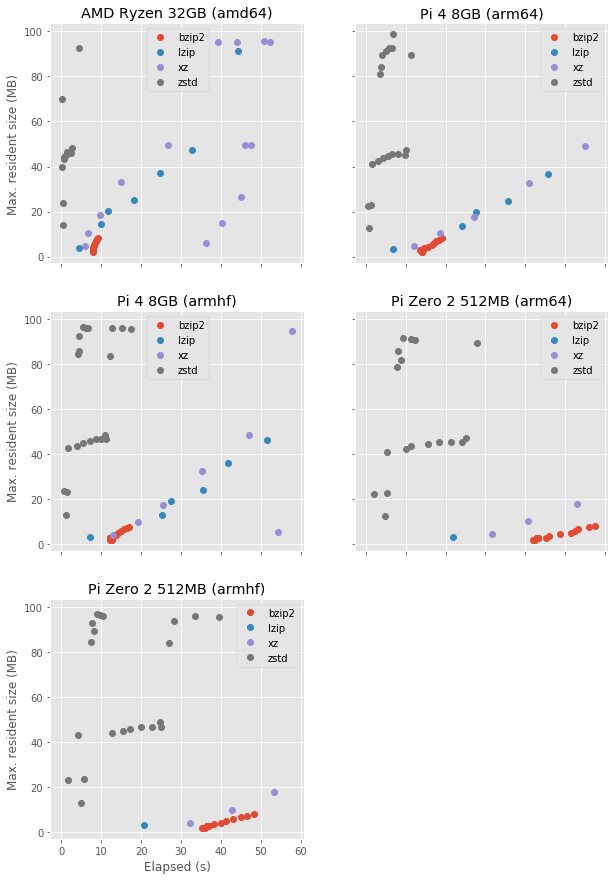

In [21]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  comp_duration AS "Elapsed (s)",
  comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND compressor IN ('bzip2', 'zstd', 'xz', 'lzip')
ORDER BY title, series
"""))

On the Pi Zero 2 at least, the `xz` and `lzip` compressors are sufficiently slow
and/or memory heavy that only a few of their data points show up under such
constraints. We can eliminate them from further consideration on this basis.

The newer `zstd` fares much better, but still has some worrying "high-memory
usage" clusters towards the top of the charts. `bzip2` appears to have decent
memory usage, but its runtimes are consistently slow (no values to the left of
the graphs). Ignoring memory usage for a second, are there *any* cases where
`bzip2` beats `zstd` on compression ratio versus speed?

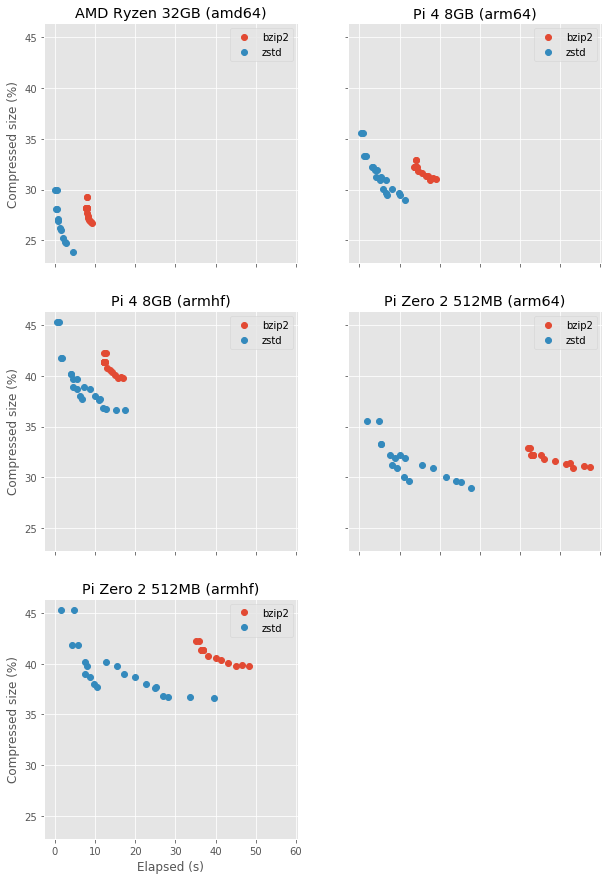

In [35]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  comp_duration AS "Elapsed (s)",
  100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND compressor IN ('bzip2', 'zstd')
ORDER BY title, series
"""))

There are not: it is always possible to produce something with `zstd` that is
smaller than the `bzip2` output, in a shorter time (at least, for our limited
set of inputs).
However, determining a
single level at which this occurs may be non-trivial given the wide range of
behaviour that `zstd` demonstrates. That said, the graphs above also remind us
that, even at `-1` level, `bzip2` is likely too slow on the Pi Zero 2.

Returning to our concern about the memory usasge of `zstd`, it is worth bearing
in mind that since the Impish release of Ubuntu (21.10), the
Ubuntu Pi kernel has shipped with a cut down list of modules which can be
expanded by installing the `linux-modules-extra-raspi` package. This can boost
the size of the initramfs quite substantially (which was a large part of the
motivation in splitting the modules out in the first place). Would this
affect the memory usage of `zstd`? In other words, is memory usage determined
partly by input size, or solely by compression level?

As it happens, our input sizes are specific to each architecture:

In [23]:
render_table(conn.execute("""
SELECT DISTINCT arch, input_size
FROM results
WHERE succeeded = 1
"""))

arch,input_size
amd64,182272000
arm64,77631488
armhf,58892800


Given this, we can query the memory usage of zstd by compression level and
architecture to take a reasonable guess at its memory usage patterns:

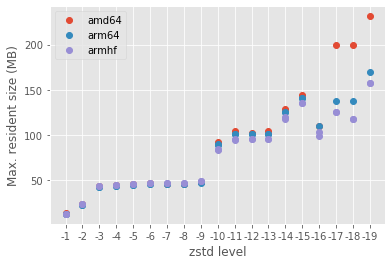

In [24]:
render_xy(conn.execute("""
SELECT
  arch,
  level AS "zstd level",
  comp_max_mem / 1048576.0 AS "Max. resident size (MB)"
FROM results
WHERE succeeded = 1
AND compressor = 'zstd'
AND options = ''
ORDER BY arch, -CAST(level AS INT)
"""))

The spread evident in the later compression levels strongly suggests that `zstd`
is variable according to input size (particularly given that the archs with the
larger inputs consistently use more memory).
Admittedly, the spread is extremely small below level `-10`. Nonetheless, the
levels from `-3` onwards all skirt very close to the 50MB "danger zone" on the
Pi Zero 2. Further, given an algorithm that explicitly varies with input size
there's no strong guarantee that later versions (or option changes) won't push
us slightly over some boundary (like 50MB resident usage).

If we selected a compressor with fixed memory usage (O(1) memory complexity),
this concern is substantially alleviated. From playing with the interactive
charts earlier, we can guess that `lz4` and `gzip` demonstrate such behaviour,
but let's confirm this by querying which compressors (and options) demonstrate
no more than 1MB of difference between their minimum and maximum memory usage
per machine (and arch):

In [25]:
render_table(conn.execute("""
SELECT
    compressor || CASE WHEN options = '' THEN '' ELSE ' ' || options END AS "Command",
    arch AS "Architecture",
    (MAX(comp_max_mem) - MIN(comp_max_mem)) / 1048576.0 AS "Mem Range (MB)"
FROM results
WHERE succeeded = 1
GROUP BY 1, 2
HAVING MAX(comp_max_mem) - MIN(comp_max_mem) <= 1048576
"""))

Command,Architecture,Mem Range (MB)
bzip2 -s,amd64,0.8203125
bzip2 -s,arm64,0.88671875
bzip2 -s,armhf,0.83203125
gzip,amd64,0.14453125
gzip,arm64,0.1171875
gzip,armhf,0.1484375
lz4,amd64,0.48046875
lz4,arm64,0.37109375
lz4,armhf,0.2578125


As suspected, `lz4` and `gzip` are (for our limited range of inputs at least),
effectively constant memory compressors.
Intriguingly, `bzip2` has a `-s` option which, according to the [manpage], is
intended to "reduce memory-usage". In fact, it seems to switch it from an
algorithm which varies (minimally) in memory usage to one that uses a fixed
size buffer. It would be ideal if `zstd` had such a switch (not to mention
`xz` and `lzip`)!

However, we've already eliminated `bzip2` over other performance concerns, and
`zstd` from levels `-3` are so close to our 50MB memory limit that we should
try and seek a reasonable alternatives if we can. `zstd` levels `-1` and `-2`
look good, but their compression ratios may not be competitive against other
combinations. How do these compare to the `lz4` and `gzip` compressors (at any
of their levels)? We'll limit the query to runs that took less than 30 seconds
and less than 50MB of resident memory:

[manpage]: https://manpages.ubuntu.com/manpages/jammy/en/man1/bzip2.1.html

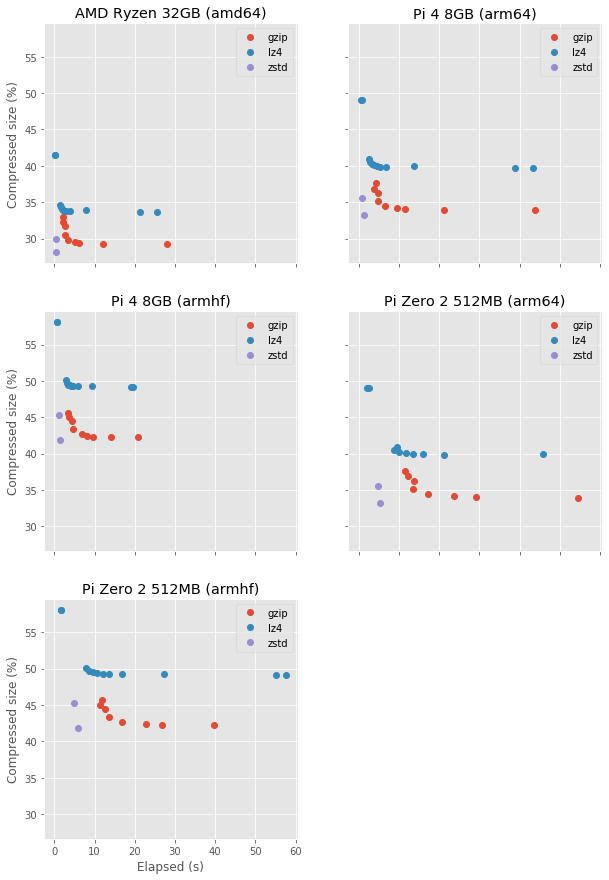

In [26]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  comp_duration AS "Elapsed (s)",
  100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
AND comp_duration < 60
AND comp_max_mem < (100 * 1048576)
AND (
    compressor IN ('gzip', 'lz4')
    OR (
        compressor = 'zstd'
        AND options = ''
        AND level IN ('-1', '-2')
    )
)
ORDER BY title, series
"""))

          1         2         3         4         5         6         7         8
012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
                                                                                |



The `-1` and `-2` levels of `zstd` look extremely good from this graph,
typically producing slightly better compression than `gzip` in roughly half the
time.

By comparison, `lz4` barely seems competitive and I have to wonder whether the
move from `gzip` to `lz4` in initramfs-tools was worthwhile (but perhaps we'll
see some difference when analyzing the decompression performance).

Playing around with the data, several conclusions should become obvious:

1. `bzip2` is slow, yet typically produces output larger than faster algorithms
   (run at lower compression levels). This suggests we should discard it from
   further consideration

1. `xz`, `lzip`, and `zstd` all use huge amounts of memory at their higher
   levels. It's telling that the Pi Zero 2 values top out at 175MB, while other
   platforms top out above 500MB. This is simply because any runs taking more
   than 175MB on the Pi Zero 2 suffered the wrath of the OOM killer. Only the
   lowest levels of these compressors can realistically be considered (at least
   for the Pi Zero 2)
   
1. The `xz` and `lzip` compressors are extremely slow, even at their lowest
   levels. Whilst they do produce better compression ratios that `zstd` at
   their lowest level, `zstd` can produce equivalent ratios in a shorter time
   at slightly higher levels. `xz` and `lzip` should therefore be discarded
   from further consideration

1. By contrast, `gzip`, `lz4`, and `bzip2` (but only with `-s`) all appear to be
   O(1) algorithms space-wise. While the `bzip2` algorithm is already discarded
   due to its relatively poor compression/time performance, it's still clearly
   the most powerful compressor amongst the fixed-memory algorithms

1. There is fascinating difference in the compression ratio of `lz4 -1` and
   `lz4 -2` in contrast to all other compressors. The `-1` and `-2` levels
   differ little in speed or memory usage, but the `-2` ratio is much better. We
   should avoid usage of `lz4 -1` in favour of `lz4 -2`.

## Compression comparisons

A quick look at how well the various options perform. We'll query only those
combinations that succeeded, limited to those that took less than 20s (otherwise
`xz` squishes everything into a corner!), categorize by the compressor, and
limit output to a single machine (and architecture) per graph (with shared axes)
at a time for ease of comparison:

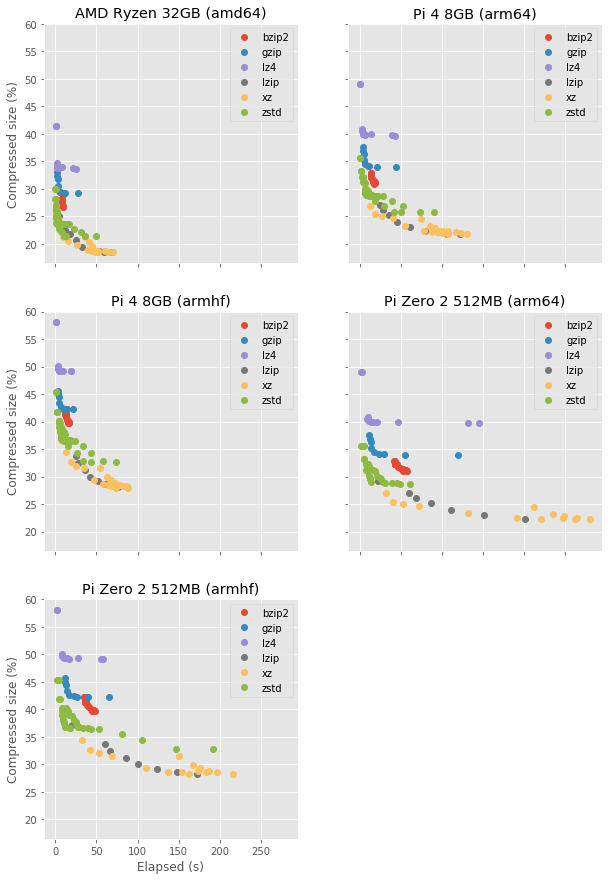

In [27]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  comp_duration AS "Elapsed (s)",
  100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
--AND comp_duration < 20
ORDER BY title, series
"""))

From the above, we can conclude:

* The patterns are fairly obvious: higher compression takes more time; each
  "sweep" of dots indicates a predictable continuum from `-1` up to `-9` (or
  whatever the range of compression levels are for a given compressor)

* `xz` is hopelessly slow; almost all its points are missing as they take more
  than 20s even on large-scale PCs, and even at minimal compression levels

* `lz4` was probably a mis-step. Whilst it's extremely fast at the `-1` end, it
  was hard-coded in `update-initramfs` with `-9` and at that level, even
  `gzip -1` beats it at compression, and is considerably faster

* `zstd -1` beats the compression ratio of `gzip` at most levels, and is within
  spitting distance of `lz4 -1` for speed (and consistently faster than
  `lz4 -2`)

## Memory pressure

How about the maximum resident size of each compressor at various levels? We'll
discount `xz` from the analysis as it's already rejected by the analysis above,
and limit the query to anything less than 100MB (otherwise `zstd` squashes
everything into a corner, particularly when running multi-threaded):

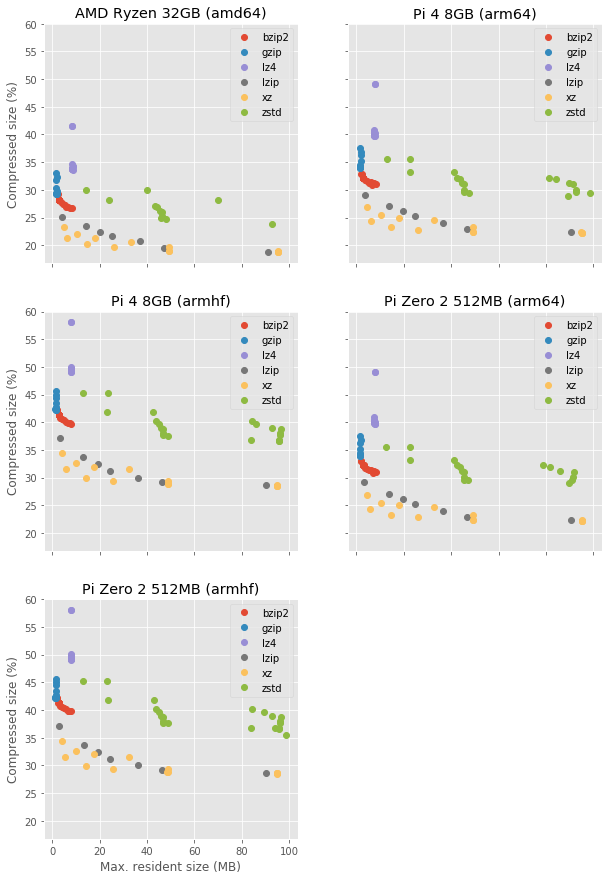

In [28]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  comp_max_mem / 1048576.0 AS "Max. resident size (MB)",
  100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
AND comp_max_mem < (100 * 1048576)
--AND compressor <> 'xz'
ORDER BY title, series
"""))

`lz4` and `gzip` both clearly use O(1) algorithms with respect to space, no matter what compression level has been selected, or the size of the input (the uncompressed initrds used on each platform varied in size from 60MB on the armhf Pi images up to 120MB on the amd64 images). Interestingly, `gzip` is also the "safest" implementation (at least from a memory usage perspective), using the smallest RSS.

`zstd` by contrast varies over an extremely wide range depending on the level selected, and the size of the input, only approaching the smaller resident sizes of `lz4` and `gzip` at the smallest levels. However, it also achieves notable compression gains over `lz4` (and `gzip`, mostly) even at those low levels. Although not shown in the graphs above, `xz` displayed similarly variable behaviour.

## Decompression comparisons

Having seen that `gzip` has the most favourable combination of memory usage, compression ratio achieved, and duration required at least on the smaller platforms, is there any advantage to `lz4` at all? For example, given that decompression is expected to be a more regular activity that compression, if `lz4` decompression is considerably faster than it may overcome any lack of compression ratio achieved.

The graph below looks at elapsed time for decompression against the compression ratio that was achieved:

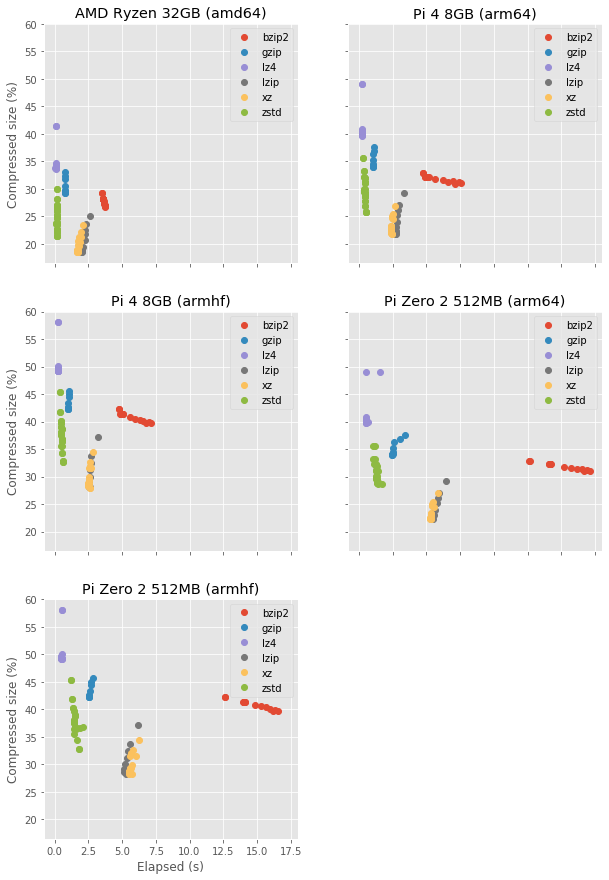

In [29]:
render_multi_xy(conn.execute("""
SELECT
  machine || ' (' || arch || ')' AS title,
  compressor AS series,
  decomp_duration AS "Elapsed (s)",
  100.0 * output_size / input_size AS "Compressed size (%)"
FROM results
WHERE succeeded = 1
ORDER BY title, series
"""))

We can immediately see that both `lz4` and `zstd` are considerably faster than the older implementations (`gzip` and `xz`). 

## Automation

Would it be possible to design some algorithm that, given an architecture and perhaps a memory size, selects an appropriate compression level (and possibly algorithm) automatically? My gut feeling is "no", and further that, even if the answer were "maybe", the result would be a maintenance nightmare. Still, let's see if there's any discernable pattern in the overall data anyway:

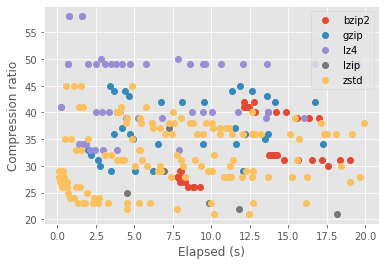

In [30]:
render_xy(conn.execute("""
SELECT
  compressor,
  comp_duration AS "Elapsed (s)",
  100 * CAST(output_size AS INTEGER) / input_size AS "Compression ratio"
FROM results
WHERE succeeded = 1
AND compressor <> 'xz'
AND comp_duration < 20
ORDER BY compressor
"""))

From the above there is a pattern, but with sufficient overlap in the performance of various compressors at various levels that any automatic algorithm would have to be per-architecture and possibly per-machine-size. That would either involve a corpus of data (which would need to be maintained in the face of advances in technology), or similar tuning parameters (which likewise would require future maintenance).

## Limits

Some additional queries to flesh out my general impression that `zstd -1` is by far the most preferable compression default:

In [31]:
render_table(conn.execute("""
WITH comp_filter(compressor, options, level) AS (
    VALUES
        ('zstd', '', '-1'),
        ('zstd', '', '-19'),
        ('lz4', '', '-9')
)
SELECT
    compressor,
    level,
    MIN(comp_duration) AS best_speed,
    MAX(comp_duration) AS worst_speed,
    MIN(CAST(output_size AS FLOAT) / input_size) AS best_ratio,
    MAX(CAST(output_size AS FLOAT) / input_size) AS worst_ratio
FROM
    results
    JOIN comp_filter USING (compressor, options, level)
WHERE succeeded = 1
GROUP BY compressor, level
ORDER BY compressor DESC, level ASC
"""))

compressor,level,best_speed,worst_speed,best_ratio,worst_ratio
zstd,-1,0.37,4.87,0.2993701281601124,0.45306636804499023
zstd,-19,49.37,192.15,0.213305724411868,0.32720918346555095
lz4,-9,3.89,21.3,0.33763590129037924,0.49243960212453813


`zstd -1` has a best time of less than a second, and a worst of no more than 5s, and it varies between compressing to roughly 30-45% of the original size.

Compare this to the prior defaults of `lz4 -9` and `zstd -19`, and bear in mind the above is across *all* architectures. The worst time of `zstd -1` (presumably on the little Pi Zero 2) is still better than the best time of `lz4 -9` (on the big fat AMD Ryzen), and while we do potentially sacrifice some compression ratio, it's still typically better than the prior `lz4 -9` default. But let's answer that more specifically:

Are there specific cases where the compression ratio of `zstd -1` is worse than `lz4 -9`, or where the elapsed time is slower?

In [32]:
render_table(conn.execute("""
WITH lz4_9 AS (
    SELECT * FROM results
    WHERE compressor = 'lz4' AND level = '-9'
),
zstd_1 AS (
    SELECT * FROM results
    WHERE compressor = 'zstd' AND options = '' AND level = '-1'
)
SELECT
    l.machine, l.arch,
    l.ratio,
    z.ratio,
    l.comp_duration, z.comp_duration
FROM lz4_9 AS l JOIN zstd_1 AS z USING (machine, arch)
WHERE l.ratio < z.ratio
OR l.comp_duration < z.comp_duration
"""))

OperationalError: no such column: l.ratio

Nope!

## Conclusion

It's indisputable that `zstd -19` provides the best compression of our available options, but it does so at the cost of a pretty extraordinary amount of memory usage (particularly compared to its forebears), making it unsafe on the smaller platforms.

Whilst it may be tempting to try and eek every last byte of compression out of the system, doing so would also impose a maintenance cost and, in light of the results above, I believe a considerable one. By comparison, switching to `zstd -1` is a win in elapsed time, memory used, and compression achieved (at least compared to the prior `lz4 -9` default).